In [87]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras_tuner as kt
import tensorflow as tf
from tensorflow import keras
from keras import models, layers, Sequential, utils, callbacks, regularizers
from tensorflow.python.client import device_lib
import datetime

In [88]:
# Enable GPUs if present
print(device_lib.list_local_devices())
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6772675985693708284
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14353956864
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6342412764165372996
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:02:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


I0000 00:00:1731449172.544652   28247 gpu_device.cc:2022] Created device /device:GPU:0 with 13689 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:02:00.0, compute capability: 8.9


In [89]:
# Define directories
data_folder = os.path.join("..", "data")
model_folder = os.path.join("..", "models")
tune_folder = os.path.join("..", "tuning")

# Seed
seed_value = 42

# Data Loading

In [90]:
image_shape = (500, 500, 3)  # Create tuple for image size
new_image_shape = (96, 96, 1)

# Establish paths
test_path = os.path.join(data_folder, "test")
train_path = os.path.join(data_folder, "train")
valid_path = os.path.join(data_folder, "valid")


# Preprocessing function
def preprocess_image(image, label):
    # Resize image
    image = tf.image.resize(image, [new_image_shape[0], new_image_shape[1]])
    # Convert image to grayscale
    image = tf.image.rgb_to_grayscale(image)
    return image, label


# Load the images sets
test_images = utils.image_dataset_from_directory(
    directory=test_path,
    labels="inferred",
    image_size=(image_shape[0], image_shape[1]),
).map(preprocess_image)

train_images = utils.image_dataset_from_directory(
    directory=train_path,
    labels="inferred",
    image_size=(image_shape[0], image_shape[1]),
).map(preprocess_image)

valid_images = utils.image_dataset_from_directory(
    directory=valid_path,
    labels="inferred",
    image_size=(image_shape[0], image_shape[1]),
).map(preprocess_image)

Found 539 files belonging to 3 classes.
Found 1942 files belonging to 3 classes.
Found 431 files belonging to 3 classes.


# Neural Network Architecture Design

In [102]:
model = Sequential(
    [
        # Image augmentation
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomBrightness(0.2),
        layers.RandomContrast(0.2),
        layers.RandomTranslation(0.2, 0.2),
        layers.RandomZoom(0.2),
        # Scaling
        layers.Rescaling(scale=1.0 / 255),  # Make life easy for the CNN
        # Convolutional network
        layers.Conv2D(
            filters=32, kernel_size=3, padding="same", activation="relu"
        ),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(
            filters=64, kernel_size=3, padding="same", activation="relu"
        ),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(
            filters=128, kernel_size=3, padding="same", activation="relu"
        ),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(
            filters=256, kernel_size=3, padding="same", activation="relu"
        ),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(
            filters=256, kernel_size=3, padding="same", activation="relu"
        ),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        # Normalize then flatten
        layers.BatchNormalization(),
        layers.Flatten(),
        # Dense network
        layers.Dense(
            128, activation="relu", kernel_regularizer=regularizers.L1L2()
        ),
        layers.Dropout(0.3),
        layers.Dense(
            128, activation="relu", kernel_regularizer=regularizers.L1L2()
        ),
        layers.Dropout(0.3),
        layers.Dense(
            3, activation="softmax", kernel_regularizer=regularizers.L1L2()
        ),
    ]
)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Training

In [103]:
# Define EarlyStopping callback
early_stopping = callbacks.EarlyStopping(
    monitor="val_accuracy",  # Metric to monitor
    patience=20,  # Number of epochs to wait for improvement
    restore_best_weights=True,  # Restore the weights of the best model
)

# Further train the best model
history = model.fit(
    train_images,
    epochs=100,
    validation_data=valid_images,
    callbacks=[early_stopping],
)

Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.3836 - loss: 1.6042 - val_accuracy: 0.2761 - val_loss: 1.1915
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.4835 - loss: 1.0933 - val_accuracy: 0.3921 - val_loss: 1.2630
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.5893 - loss: 0.8823 - val_accuracy: 0.4919 - val_loss: 0.9863
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.6253 - loss: 0.7819 - val_accuracy: 0.4107 - val_loss: 1.1561
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.6530 - loss: 0.7199 - val_accuracy: 0.4664 - val_loss: 0.9702
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.6516 - loss: 0.7120 - val_accuracy: 0.2993 - val_loss: 1.1830
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.6686 - loss: 0.6536 - val_accuracy: 0.5406 - val_loss: 0.7588
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.6951 - loss: 0.6190 - val_accuracy: 0.

# Model Evaluation

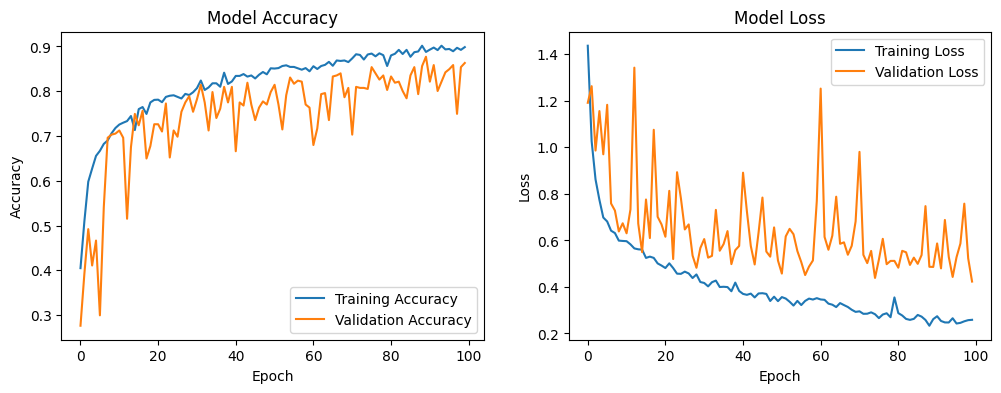

In [104]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [105]:
# Save the model
model_path = os.path.join(
    model_folder,
    f"model_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.keras",
)
model.save(model_path)

# Model Testing

In [106]:
# Load the model
model = models.load_model(model_path, safe_mode=False)

# Evaluate on test data
test_loss, test_acc = model.evaluate(x=test_images)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8728 - loss: 0.2973
